[![](https://colab.research.google.com/assets/colab-badge.svg "Open in Colab button")](https://colab.research.google.com/github/thinkingmachines/geowrangler/blob/feat/upgrade-nbdev2/notebooks/08_raster_to_dataframe.ipynb)

In [1]:
#| default_exp raster_to_dataframe

In [2]:
#| include: false
# all_slow

In [3]:
#| include: false
#| no_test
! [ -e /content ] && pip install -Uqq geowrangler

In [4]:
#| include: false
#| no_test
!mkdir -p ../data
![ -e /content ] && ln -s ../data .

In [5]:
#| include: false
#| no_test
!mkdir -p ../data
# download sample geojson files from repo

In [6]:
#| include: false
#| no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
#| include: false
import warnings

from shapely.errors import ShapelyDeprecationWarning

In [8]:
#| include: false
warnings.filterwarnings(action="ignore", category=UserWarning, module="geopandas")
warnings.filterwarnings(
    action="ignore", category=ShapelyDeprecationWarning, module="pandas"
)

In [9]:
#| export
import json
from typing import Any, Dict, List

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import rasterio as rio
import rasterio.mask

In [10]:
from rasterio import features
from rasterio.plot import show
from rasterio.windows import Window, transform

### Vector to Raster mask

> convert vectors into raster masks where each pixel is a numerical representation of a label/category

In [11]:
#| exporti
def _explode(gdf):
    """
    Explodes a geodataframe
    Source: https://gist.github.com/mhweber/cf36bb4e09df9deee5eb54dc6be74d26
    Will explode muti-part geometries into single geometries.
    Args:
        gdf (gpd.GeoDataFrame) : Input geodataframe with multi-geometries
    Returns:
        gdf (gpd.GeoDataFrame) : Exploded geodataframe with a new index
                                 and two new columns: level_0 and level_1
    """

    gs = gdf.explode(index_parts=True)
    gdf2 = gs.reset_index().rename(columns={0: "geometry"})
    if "class" in gdf2.columns:
        gdf2 = gdf2.drop("class", axis=1)
    gdf_out = gdf2.merge(
        gdf.drop("geometry", axis=1), left_on="level_0", right_index=True
    )
    gdf_out = gdf_out.set_index(["level_0", "level_1"]).set_geometry("geometry")
    gdf_out.crs = gdf.crs

    return gdf_out

In [12]:
#| export

GRID_ID = 1


def generate_mask(
    tiff_file,  # Path to reference TIFF file
    shape_file,  # Path to shapefile
    output_file,  # Path to output file
    labels_column,  # Feature in the shapefile that contains labels/categories
    labels_dict: Dict[  # Dictionary of desired labels and assigned values for the mask
        str, int
    ],
    plot=False,  # Plots vector, reference TIF image, and raster mask output
):
    """Generates a segmentation mask for one TIFF image.
    Returns:
        image (np.array): A binary mask as a numpy array
    """
    global GRID_ID

    src = rio.open(tiff_file)
    raw = gpd.read_file(shape_file).dropna()
    gdf = _explode(raw)

    label_values = {}

    labels_column = f"{labels_column}_x"

    if labels_column in gdf.columns:
        for keys, values in labels_dict.items():
            label_values[keys] = values

    masks, grids = [], []
    for index, (idx, x) in enumerate(gdf.iterrows()):

        if labels_column in x:
            value = label_values[x[labels_column]]
        gdf_json = json.loads(gpd.GeoDataFrame(pd.DataFrame(x).T).to_json())
        feature = [gdf_json["features"][0]["geometry"]][0]
        masks.append((feature, value))
        grids.append((feature, GRID_ID))
        GRID_ID += 1

    masks = rio.features.rasterize(
        ((g, v) for (g, v) in masks),
        out_shape=src.shape,
        transform=src.transform,
    ).astype(rio.uint16)

    grids = rio.features.rasterize(
        ((g, v) for (g, v) in grids),
        out_shape=src.shape,
        transform=src.transform,
    ).astype(rio.uint16)

    out_meta = src.meta.copy()
    out_meta["count"] = 2
    out_meta["nodata"] = 0
    out_meta["dtype"] = rio.uint16
    out_meta["compress"] = "deflate"

    with rio.open(output_file, "w", **out_meta) as dst:
        dst.write(masks, indexes=1)
        dst.write(grids, indexes=2)

    if plot:
        f, ax = plt.subplots(1, 3, figsize=(15, 15))
        gdf.plot(ax=ax[0])
        rio.plot.show(src, ax=ax[1], adjust=None)
        rio.plot.show(masks, ax=ax[2], adjust=None)

        ax[0].set_title("Vector File")
        ax[1].set_title("TIFF")
        ax[2].set_title("Masked")
        plt.show()

    return masks, grids, label_values

### Raster to Dataframe

> Reads the bands for each image in the list and returns a dataframe where each band is one column with the image name as a suffix for column name.

In [13]:
#| export
def read_bands(image_list: List[str], mask: str):

    data = []

    label_ = rio.open(mask)
    label = label_.read(1).ravel()

    # Iterate over each year
    for idx, image_file in enumerate(image_list):
        # Read each band
        subdata = dict()
        raster = rio.open(image_file)

        for band_idx in range(raster.count):
            band = raster.read(band_idx + 1).ravel()
            subdata["B{}".format(band_idx + 1)] = band

        # Cast to pandas subdataframe
        subdata = pd.DataFrame(subdata).fillna(0)
        subdata.columns = [column + "_" + str(idx) for column in subdata.columns]

        data.append(subdata)
        del subdata

    data = pd.concat(data, axis=1)
    data["label"] = label

    return data

## Test data

### Generating a raster mask

In [14]:
# Get filepaths
tiff_file = "../data/vector_to_raster_mask_sample/cabanglasan.tif"
shape_file = "../data/vector_to_raster_mask_sample/labels_20220816.gpkg"
target_file = shape_file.replace("gpkg", "tiff")

Given a raster image of a certain area that will be masked to use as a reference and a shape file that contains that area. Note that the shape file must include a column that contains labels/categories. 

In [15]:
gpd.read_file(shape_file).head(3)

,year,label,uid,ADM3_EN,ADM3_PCODE,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,geometry
0,2017.0,mining,72_2017_mining,Sofronio Española,PH175324000,Palawan,PH175300000,Region IV-B,PH170000000,"MULTIPOLYGON Z (((117.95961 9.03303 0.00000, 1..."
1,2017.0,mining,71_2017_mining,Sofronio Española,PH175324000,Palawan,PH175300000,Region IV-B,PH170000000,"MULTIPOLYGON Z (((117.95507 9.03809 0.00000, 1..."
2,2017.0,mining,70_2017_mining,Sofronio Española,PH175324000,Palawan,PH175300000,Region IV-B,PH170000000,"MULTIPOLYGON Z (((117.95663 9.03869 0.00000, 1..."


And a dictionary with your desired labels and assigned values in creating a mask

In [16]:
labels = {
    "mining": 1,
    "neg": 2,
    "agriculture": 3,
    "product_extraction": 4,
    "kaingin": 5,
    "biophysical": 6,
}

Input them in the `generate_mask` function to create a raster mask of the same dimension as the reference raster image

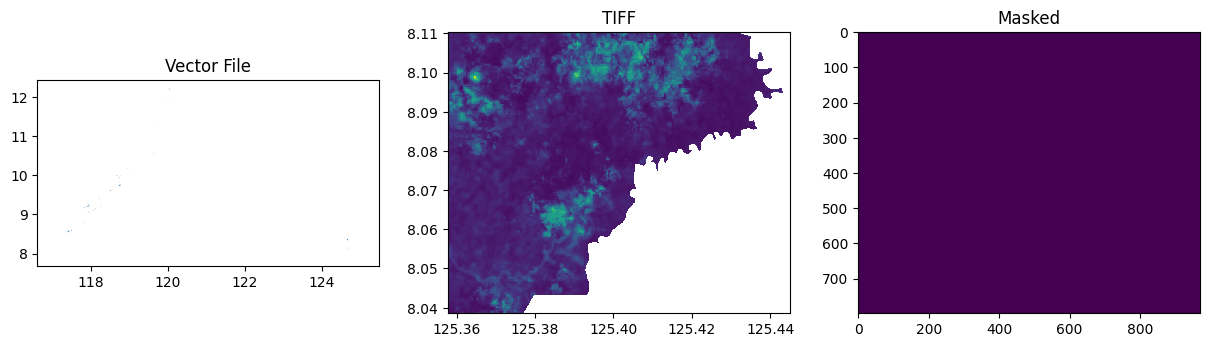

In [17]:
# Generate masks for a file
masks, grids, values = generate_mask(
    tiff_file=tiff_file,
    shape_file=shape_file,
    output_file=target_file,
    labels_column="label",
    labels_dict=labels,
    plot=True,
)

In [18]:
masks

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [19]:
grids

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [20]:
values

{'mining': 1,
 'neg': 2,
 'agriculture': 3,
 'product_extraction': 4,
 'kaingin': 5,
 'biophysical': 6}

Choose raster images to convert into a dataframe and use the generated raster mask to add the labels the converted dataframe.

In [21]:
tiff_files = ["../data/vector_to_raster_mask_sample/cabanglasan.tif"]
mask_file = "../data/vector_to_raster_mask_sample/labels_20220816.tiff"

In [22]:
data = read_bands(tiff_files, mask_file)

In [23]:
data

,B1_0,B2_0,B3_0,B4_0,B5_0,B6_0,B7_0,B8_0,B9_0,B10_0,B11_0,B12_0,label
0,0.1198,0.09635,0.09330,0.0698,0.10665,0.20250,0.2490,0.23525,0.28125,0.0377,0.19925,0.1002,0
1,0.1198,0.09580,0.09245,0.0708,0.10665,0.20250,0.2490,0.23925,0.28125,0.0377,0.19925,0.1002,0
2,0.1148,0.09420,0.09460,0.0707,0.10380,0.20395,0.2478,0.23150,0.27165,0.0385,0.18240,0.0902,0
3,0.1148,0.09190,0.08850,0.0631,0.10380,0.20395,0.2478,0.23300,0.27165,0.0385,0.18240,0.0902,0
4,0.1148,0.09350,0.09080,0.0643,0.10565,0.20830,0.2466,0.24205,0.26990,0.0385,0.18050,0.0894,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
775824,0.0000,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000,0.0000,0
775825,0.0000,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000,0.0000,0
775826,0.0000,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000,0.0000,0
775827,0.0000,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000,0.0000,0
